***FineTuning mistral for cutsom llm using qLora ***

we can train on our own data or data of any specific comapny

---



In [ ]:
!pip install -q datasets torch trl bitsandbytes accelerate wandb
!pip install -q tiktoken

In [ ]:
!pip install --upgrade transformers


In [ ]:

!pip install git+https://github.com/huggingface/peft.git

  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-ghopa2uh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-ghopa2uh
  Resolved https://github.com/huggingface/peft.git to commit 58afb34ea03ae1166fc331adee0b4646e46db6dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peft: filename=peft-0.11.2.dev0-py3-none-any.whl size=270929 sha256=ba72ac64816c92f4f6c41c73fe8596acd5139986b3e1effff323782ba3d3a67f
  Stored in directory: /tmp/pip-ephem-wheel-cache-j8y8zhc2/wheels/d7/c7/de/1368fac8590e1b103ddc2ec2a28ad51d83aded1a3830e8a087
Successfully built peft


In [ ]:
import datasets
import tiktoken
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from trl import SFTTrainer
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments,BitsAndBytesConfig
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model, PeftModel
import wandb
from huggingface_hub import HfApi, notebook_login

In [ ]:
from datasets import load_dataset

ds = load_dataset("Open-Orca/OpenOrca")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
data = ds['train']
print(data)
# Function to count tokens
def num_tokens(text, model="gpt-3.5-turbo-0301"):
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

Dataset({
    features: ['id', 'system_prompt', 'question', 'response'],
    num_rows: 4233923
})


In [ ]:
def filter_by_token_count(example):
    return num_tokens(example['response']) >= 100

filtered_data = data.filter(filter_by_token_count)

Filter:   0%|          | 0/4233923 [00:00<?, ? examples/s]

In [ ]:
print(len(filtered_data))
print("remaining dataset length(compared to original):",((len(filtered_data))/4233923)*100)


1561276
remaining dataset length(compared to original): 36.87539900938208


In [ ]:

def deduplicate(data, threshold=0.95, batch_size=1000):
    vectorizer = CountVectorizer(binary=True)
    unique_indices = set()

    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]

        # Create binary vectors for responses
        vectors = vectorizer.fit_transform(batch['response'])

        # Calculate cosine similarity
        cosine_sim = cosine_similarity(vectors)

        # Remove similar responses
        for j in range(len(batch)):
            if i+j not in unique_indices:
                unique_indices.add(i+j)
                similar_indices = np.where(cosine_sim[j] > threshold)[0]
                unique_indices.update(i+k for k in similar_indices if k != j)

    return list(unique_indices)

unique_indices = deduplicate(filtered_data)
deduplicated_data = filtered_data.select(unique_indices)


In [ ]:
print(f"Original dataset size: {len(filtered_data)}")
print(f"Deduplicated dataset size: {len(deduplicated_data)}")
print(f"Percentage retained: {len(deduplicated_data) / len(filtered_data) * 100:.2f}%")

Original dataset size: 1561276
Deduplicated dataset size: 6249
Percentage retained: 0.40%


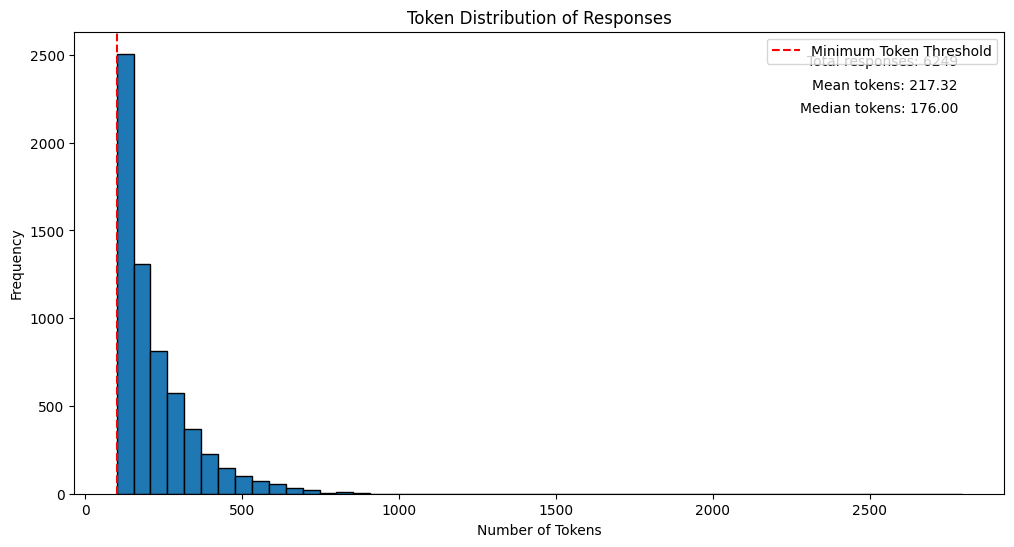

Token distribution graph saved as 'token_distribution.png'
Minimum token count: 100
Maximum token count: 2794
Mean token count: 217.32
Median token count: 176.00


In [ ]:

token_counts = [num_tokens(item['response']) for item in deduplicated_data]
plt.figure(figsize=(12, 6))
plt.hist(token_counts, bins=50, edgecolor='black')
plt.title('Token Distribution of Responses')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(x=100, color='r', linestyle='--', label='Minimum Token Threshold')
plt.legend()
plt.text(0.95, 0.95, f'Total responses: {len(token_counts)}',
         transform=plt.gca().transAxes, ha='right', va='top')
plt.text(0.95, 0.90, f'Mean tokens: {np.mean(token_counts):.2f}',
         transform=plt.gca().transAxes, ha='right', va='top')
plt.text(0.95, 0.85, f'Median tokens: {np.median(token_counts):.2f}',
         transform=plt.gca().transAxes, ha='right', va='top')
plt.show()

plt.close()

print(f"Token distribution graph saved as 'token_distribution.png'")
print(f"Minimum token count: {min(token_counts)}")
print(f"Maximum token count: {max(token_counts)}")
print(f"Mean token count: {np.mean(token_counts):.2f}")
print(f"Median token count: {np.median(token_counts):.2f}")

In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [ ]:


hf_dataset = Dataset.from_dict({
    'id': deduplicated_data['id'],
    'system_prompt': deduplicated_data['system_prompt'],
    'question': deduplicated_data['question'],
    'response': deduplicated_data['response']
})


hf_username = "harshThakur9089798"
dataset_name = "filtered-openorca-v1"

dataset_card = f"""
---
language:
- en
license:
- cc-by-sa-4.0
---

# Dataset Card for {dataset_name}

This dataset is a filtered and deduplicated version of the OpenOrca dataset. It contains {len(hf_dataset)} samples.

## Dataset Details

- The dataset has been filtered to include only responses with 100 or more tokens.
- Deduplication has been performed using cosine similarity with a threshold of 0.95.
- The dataset contains four fields: 'id', 'system_prompt', 'question', and 'response'.
- Original dataset: OpenOrca

"""

with open("README.md", "w") as f:
    f.write(dataset_card)
hf_dataset.push_to_hub(f"{hf_username}/{dataset_name}", private=True)

api = HfApi()
api.upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",
    repo_id=f"{hf_username}/{dataset_name}",
    repo_type="dataset"
)

print(f"Dataset uploaded successfully to https://huggingface.co/datasets/{hf_username}/{dataset_name}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Dataset uploaded successfully to https://huggingface.co/datasets/harshThakur9089798/filtered-openorca-v1


In [ ]:
from datasets import load_dataset
dataset_name = "harshThakur9089798/filtered-openorca-v1"
dataset = load_dataset(dataset_name)
train_dataset = dataset['train']

print(f"Training set size: {len(train_dataset)}")
print(train_dataset[0])

Generating train split:   0%|          | 0/6249 [00:00<?, ? examples/s]

Training set size: 6249
{'id': 'cot.86217', 'system_prompt': 'You are an AI assistant that helps people find information.', 'question': "James runs a TV show and there are 5 main characters and 4 minor characters. He pays the minor characters $15,000 each episode. He paid the major characters three times as much. How much does he pay per episode? Let's be accurate as possible.", 'response': 'James pays the minor characters $15,000 each episode. Since there are 4 minor characters, he pays them a total of 4 * $15,000 = $60,000 per episode.\n\nThe major characters are paid three times as much. So, each major character gets paid 3 * $15,000 = $45,000 per episode.\n\nThere are 5 main characters, so he pays them a total of 5 * $45,000 = $225,000 per episode.\n\nIn total, James pays $225,000 (major characters) + $60,000 (minor characters) = $285,000 per episode.'}


In [ ]:
notebook_login()

In [ ]:
model_name = "mistralai/Mistral-7B-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
model.config.use_cache = False
model.config.pretraining_tp = 1


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)
print("QLoRA model prepared successfully!")

QLoRA model prepared successfully!


In [ ]:
output_dir = "./results"
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    save_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    max_steps=100,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to=["wandb"]
)

wandb.login()
wandb.init(project="mistral-finetuning", name="mistral-finetuning-run-1")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: harshthakur9415 (harshthakur9415-). Use `wandb login --relogin` to force relogin


In [ ]:
def format_dataset(example):
    return {
        "text": f"System: {example['system_prompt']}\nHuman: {example['question']}\nAssistant: {example['response']}"
    }
formatted_dataset = train_dataset.map(format_dataset)

Map:   0%|          | 0/6249 [00:00<?, ? examples/s]

In [ ]:
from trl import SFTTrainer
max_seq_length = 512
trainer = SFTTrainer(
    model=model,
    train_dataset=formatted_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/6249 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

KeyboardInterrupt: 

In [ ]:
trainer.model.save_pretrained("./mistral-finetune-qlora")

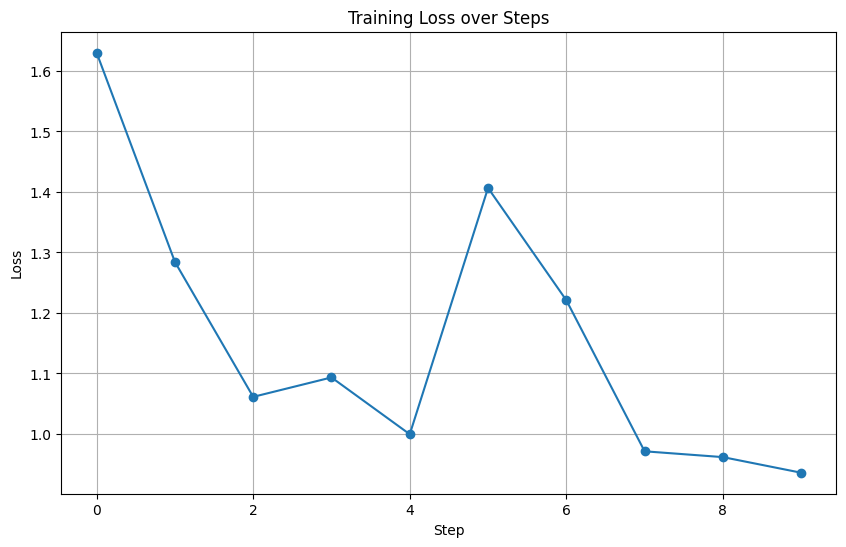

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('wandb_export_2024-07-08T23_47_18.220+05_30.csv')
plt.figure(figsize=(10, 6))
plt.plot(data['Step'], data['mistral-finetuning-run-1 - train/loss'], marker='o')
plt.title('Training Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
def generate_response(prompt, model, tokenizer, max_new_tokens=512):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True, top_p=0.9, temperature=0.7)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response
prompt = "hi! how are you?"
response = generate_response(prompt, model, tokenizer)
print("Response:", response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Response: hi! how are you? i'm fine, thank you.
Happy to see you here! I'm looking for a place to stay in your city for a few days.
I'm looking for a place to stay in your city for a few days.
I'm looking for a place to stay in your city for a few days.
I'm looking for a place to stay in your city for a few days.
I'm looking for a place to stay in your city for a few days.

# 10 Unusual Places to Stay in the World

Traveling is one of the best ways to escape the daily routine and experience something new. While there are plenty of great hotels around the world, why not try something different? If you’re looking for an unusual place to stay, here are some of the most unique accommodations in the world.

## 1. The Library at the Fullerton Hotel, Singapore

The Fullerton Hotel in Singapore is a historic landmark that was once the headquarters of the Singapore General Post Office. The Library, a suite on the hotel’s top floor, is a luxurious and unique accommodation. The suite features a p

In [ ]:
model.push_to_hub("mistral-finetune-lora")

adapter_model.safetensors:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/harshThakur9089798/mistral-finetune-lora/commit/c20277c0d7c7adca31eb7c614f4515a943cbf203', commit_message='Upload model', commit_description='', oid='c20277c0d7c7adca31eb7c614f4515a943cbf203', pr_url=None, pr_revision=None, pr_num=None)